# COVID-19-detection-ML-DL
Детектирование наличия COVID-19 либо вирусной пневмонии на рентгеновских снимках легких с помощью алгоритмов машинного и глубокого обучения.

## Оглавление
1) Загрузка необходимых библиотек и инструментов.
- os
- cv2
- scikit-image
- numpy
2) Создание отдельных функций:
- загрузки изображений
- выделения LBP-признаков
- разметки примеров.
3) Загрузка и предобработка датасета

In [2]:
# Загрузка необходимых библиотек и инструментов
import os # Библиотека для работы с функциями ОС
import cv2 # Библиотека для работы с изображениями
from skimage.feature import local_binary_pattern # Инструмент извлечения LBP-признаков
import numpy as np # Библиотека для математических операций
import matplotlib.pyplot as plt # Библиотека для визуализации данных
import seaborn as sns # Библиотека для визуализации данных
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report # Матрица ошибок и отчет по классификации
from sklearn.neighbors import KNeighborsClassifier # Метод KNN
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # Методы RandomForestTree и GradientBoostingClassifier
from concurrent.futures import ThreadPoolExecutor # Параллельная реализация процессов

In [3]:
# Функция загрузки изображений
def image_load(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(directory,filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                images.append(image)
    return images

In [4]:
# Функция выделения LBP-признаков
def lbp_features(image):
    # Извлечение LBP-признаков
    lbp = local_binary_pattern(
        image=image,
        P=2,
        R=1,
        method='uniform'
        )
    # Вычисляем гистограмму признаков
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins))
    # Нормализуем гистограмму
    hist = hist / hist.sum()
    return hist

In [5]:
# Функция подсчета количества примеров в директории
def count_image_files(directory):
    count = 0
    for filename in os.listdir(directory):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            count += 1
    return count

In [6]:
# Функция для параллельной обработки изображений
def process_images_parallel(images, max_workers=None):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        features = list(executor.map(lbp_features, images))
    return features

Использован следующий [датасет](https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset/). Для осуществления обучения и проверки моделей необходимо провести предварительную обработку изображений.

In [7]:
# Директории датасета
directories = [
    "Covid19-dataset/train/Normal",
    "Covid19-dataset/train/Viral_Pneumonia",
    "Covid19-dataset/train/Covid",
    "Covid19-dataset/test/Normal",
    "Covid19-dataset/test/Viral_Pneumonia",
    "Covid19-dataset/test/Covid"
]

In [8]:
# Список для сохранения результатов
image_datasets = [None] * len(directories)

In [9]:
# Параллельная загрузка
with ThreadPoolExecutor() as executor:
    futures = []
    for i, directory in enumerate(directories):
        futures.append(executor.submit(image_load, directory))
    
    for i, future in enumerate(futures):
        image_datasets[i] = future.result()

In [10]:
# Загрузка изображений из директорий
images_train_Normal = []
images_train_Normal = image_load(directory=directories[0])
#
images_train_Viral_Pneumonia = []
images_train_Viral_Pneumonia = image_load(directory=directories[1])
#
images_train_Covid = []
images_train_Covid = image_load(directory=directories[2])
#
images_test_Normal = []
images_test_Normal = image_load(directory=directories[3])
#
images_test_Viral_Pneumonia = []
images_test_Viral_Pneumonia = image_load(directory=directories[4])
#
images_test_Covid = []
images_test_Covid = image_load(directory=directories[5])

In [11]:
# Параллельное выделение признаков для обучающих данных
X_train_Normal = []
X_train_Normal = process_images_parallel(images_train_Normal)
#
X_train_Viral_Pneumonia = []
X_train_Viral_Pneumonia = process_images_parallel(images_train_Viral_Pneumonia)
#
X_train_Covid = []
X_train_Covid = process_images_parallel(images_train_Covid)
#
X_train = []
X_train = np.concatenate([X_train_Normal, X_train_Viral_Pneumonia, X_train_Covid])
#
# Параллельное выделение признаков для тестовых данных
X_test_Normal = []
X_test_Normal = process_images_parallel(images_test_Normal)
#
X_test_Viral_Pneumonia = []
X_test_Viral_Pneumonia = process_images_parallel(images_test_Viral_Pneumonia)
#
X_test_Covid = []
X_test_Covid = process_images_parallel(images_test_Covid)
#
X_test = []
X_test = np.concatenate([X_test_Normal, X_test_Viral_Pneumonia, X_test_Covid])

In [12]:
# Разметка примеров
# 'Normal' = 0
# 'Viral_Pneumonia' = 1
# 'Covid' = 2
#
# Количество файлов в директориях датасета
train_normal_count = count_image_files(directories[0])
train_viral_count = count_image_files(directories[1])
train_covid_count = count_image_files(directories[2])
#
test_normal_count = count_image_files(directories[3])
test_viral_count = count_image_files(directories[4])
test_covid_count = count_image_files(directories[5])
#
# Создание массивов меток
y_train_normal = np.zeros(train_normal_count) 
y_train_viral = np.ones(train_viral_count)     
y_train_covid = np.full(train_covid_count, 2)
y_train = np.concatenate([y_train_normal, y_train_viral, y_train_covid])
#
y_test_normal = np.zeros(test_normal_count)
y_test_viral = np.ones(test_viral_count)
y_test_covid = np.full(test_covid_count, 2)
y_test = np.concatenate([y_test_normal, y_test_viral, y_test_covid])

### Обучение и проверка моделей на основе классических алгоритмов машинного обучения (KNearestNeighbors, RandomForestTree и GradientBoosting)

<Figure size 600x600 with 0 Axes>

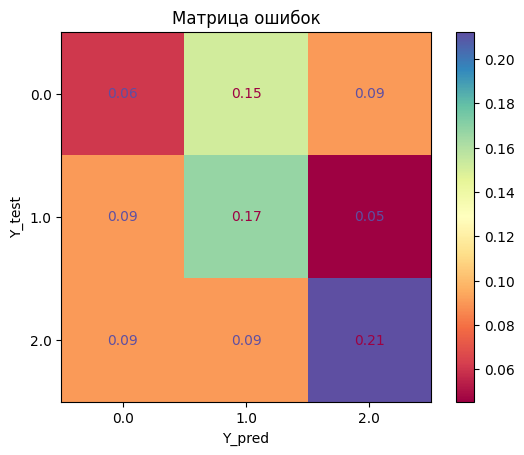

              precision    recall  f1-score   support

      Normal       0.25      0.20      0.22        20
       Viral       0.41      0.55      0.47        20
    Covid-19       0.61      0.54      0.57        26

    accuracy                           0.44        66
   macro avg       0.42      0.43      0.42        66
weighted avg       0.44      0.44      0.43        66



In [13]:
# Обучение и проверка модели на основе KNearestNeighbors
model_KNN = KNeighborsClassifier(n_neighbors=10**1) # инициализация модели на основе KNearestNeighbors
model_KNN.fit(X_train,y_train) # обучение модели
y_pred = model_KNN.predict(X_test) # тестирование модели
cm_model_KNN = confusion_matrix(y_test,y_pred, normalize='all') # матрица ошибок
#
#Визуализация матрицы ошибок
plt.figure(figsize=(6,6))
graph = ConfusionMatrixDisplay(confusion_matrix=cm_model_KNN, display_labels=model_KNN.classes_)
graph.plot(cmap='Spectral', values_format='.2f')
plt.xlabel('Y_pred')
plt.ylabel('Y_test')
plt.title('Матрица ошибок')
plt.show()
#
# Отчет по классификации
print(classification_report(y_test,y_pred, target_names=['Normal','Viral','Covid-19']))

<Figure size 600x600 with 0 Axes>

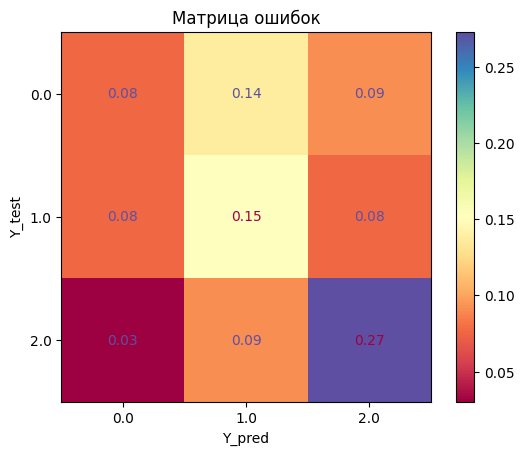

              precision    recall  f1-score   support

      Normal       0.42      0.25      0.31        20
       Viral       0.40      0.50      0.44        20
    Covid-19       0.62      0.69      0.65        26

    accuracy                           0.50        66
   macro avg       0.48      0.48      0.47        66
weighted avg       0.49      0.50      0.49        66



In [14]:
# Обучение и проверка модели на основе RandomForestTree
model_RFT = RandomForestClassifier(random_state=18) # инициализация модели на основе RandomForestTree
model_RFT.fit(X_train, y_train) # обучение модели
y_pred = model_RFT.predict(X_test) # тестирование модели
cm_model_RFT = confusion_matrix(y_test,y_pred, normalize='all') # матрица ошибок
#
#Визуализация матрицы ошибок
plt.figure(figsize=(6,6))
graph = ConfusionMatrixDisplay(confusion_matrix=cm_model_RFT, display_labels=model_RFT.classes_)
graph.plot(cmap='Spectral', values_format='.2f')
plt.xlabel('Y_pred')
plt.ylabel('Y_test')
plt.title('Матрица ошибок')
plt.show()
#
# Отчет по классификации
print(classification_report(y_test,y_pred, target_names=['Normal','Viral','Covid-19']))

<Figure size 600x600 with 0 Axes>

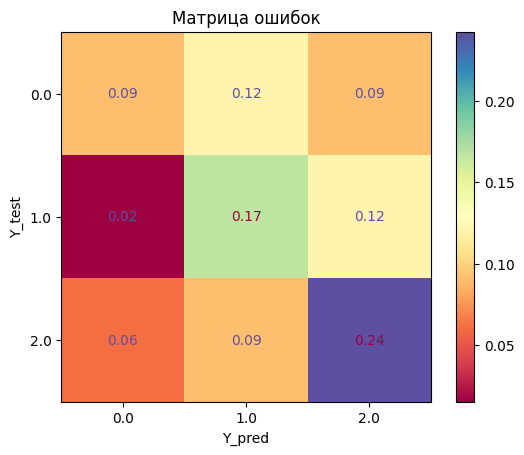

              precision    recall  f1-score   support

      Normal       0.55      0.30      0.39        20
       Viral       0.44      0.55      0.49        20
    Covid-19       0.53      0.62      0.57        26

    accuracy                           0.50        66
   macro avg       0.51      0.49      0.48        66
weighted avg       0.51      0.50      0.49        66



In [15]:
# Обучение и проверка модели на основе GradientBoosting
model_GB = GradientBoostingClassifier(random_state=18) # Инициализация модели на основе GradientBoosting
model_GB.fit(X_train, y_train) # обучение модели
y_pred = model_GB.predict(X_test) # тестирование модели
cm_model_GB = confusion_matrix(y_test,y_pred, normalize='all') # матрица ошибок
#
#Визуализация матрицы ошибок
plt.figure(figsize=(6,6))
graph = ConfusionMatrixDisplay(confusion_matrix=cm_model_GB, display_labels=model_GB.classes_)
graph.plot(cmap='Spectral', values_format='.2f')
plt.xlabel('Y_pred')
plt.ylabel('Y_test')
plt.title('Матрица ошибок')
plt.show()
#
# Отчет по классификации
print(classification_report(y_test,y_pred, target_names=['Normal','Viral','Covid-19']))